In [ ]:
# Laurent LEQUIEVRE
# Research Engineer, CNRS (France)
# Institut Pascal UMR6602
# laurent.lequievre@uca.fr

# Solution based on :
# https://www.kaggle.com/wuhao1542/pytorch-rl-0-frozenlake-q-network-learning

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np 

In [89]:
import gym
from gym.envs.registration import register

In [90]:
import matplotlib.pyplot as plt

In [91]:
# If you got that error after a registration :
# Error: Cannot re-register id: FrozenLakeNotSlippery-v0
# So you need to delete an env registered

env_dict = gym.envs.registration.registry.env_specs.copy()

for env in env_dict:
    if 'FrozenLakeNotSlippery-v0' in env:
        print("Remove {} from registry".format(env))
        del gym.envs.registration.registry.env_specs[env]


Remove FrozenLakeNotSlippery-v0 from registry


In [92]:
register(
   id="FrozenLakeNotSlippery-v0",
   entry_point='gym.envs.toy_text:FrozenLakeEnv',
   kwargs={'map_name': '4x4', 'is_slippery': False},
)

env = gym.make("FrozenLakeNotSlippery-v0")

In [93]:
observation_space = env.observation_space.n
action_space = env.action_space.n

print("observation space = {}, action space = {}".format(observation_space, action_space))

observation space = 16, action space = 4


In [94]:
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [95]:
print(env.desc)

desc = env.desc.tolist()
desc = [[c.decode("utf-8") for c in line] for line in desc]
print(desc)

index_of_goal = env.observation_space.n - 1
print(index_of_goal)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]
[['S', 'F', 'F', 'F'], ['F', 'H', 'F', 'H'], ['F', 'F', 'F', 'H'], ['H', 'F', 'F', 'G']]
15


In [96]:
def get_index_of_holes(an_env):
    
    env_list = [[c.decode("utf-8") for c in line] for line in an_env.desc]
    index_holes = []
    
    size = np.int64(np.sqrt(an_env.observation_space.n))
    
    for i in range(size):
        for j in range(size):
            c = env_list[i][j]
            if (c == 'H'):
                index_holes.append(i*size+j)
    return index_holes


l = get_index_of_holes(env)

print("Indexes of Holes = {}".format(l))

Indexes of Holes = [5, 7, 11, 12]


In [97]:
def uniform_linear_layer(linear_layer):
    linear_layer.weight.data.uniform_()
    linear_layer.bias.data.fill_(-0.02)

class Agent(nn.Module):
    def __init__(self, observation_space_size, action_space_size):
        super(Agent, self).__init__()
        self.observation_space_size = observation_space_size
        self.hidden_size = observation_space_size
        self.l1 = nn.Linear(in_features=observation_space_size, out_features=self.hidden_size)
        self.l2 = nn.Linear(in_features=self.hidden_size, out_features=action_space_size)
        uniform_linear_layer(self.l1)
        uniform_linear_layer(self.l2)
    
    def forward(self, state):
        obs_emb = F.one_hot(torch.LongTensor([int(state)]), num_classes=self.observation_space_size)
        out1 = torch.sigmoid(self.l1(obs_emb.float()))
        return self.l2(out1).view((-1)) # 1 x ACTION_SPACE_SIZE == 1 x 4  =>  4

In [121]:
def take_action(action, env, indexes_of_holes):
    new_state, reward, done, info = env.step(action)
    index_of_goal = env.observation_space.n - 1
    # Reward function
    # if new_state is a Hole
    #if new_state in [5, 7, 11, 12]:
    if new_state in indexes_of_holes:
        reward = -1
    # else if new_state is the Goal (Final State)
    elif new_state == index_of_goal:
        reward = 1
    # else penalize research
    else:
        reward = -0.01
    return new_state, reward, done, info

class Trainer:
    def __init__(self, env):
        self.agent = Agent(env.observation_space.n, env.action_space.n)
        self.optimizer = optim.Adam(params=self.agent.parameters())
        self.env = env
        self.indexes_of_holes = get_index_of_holes(self.env)
        self.gamma = 0.99
        self.scores = []  # list containing scores from each episode
        self.mean_losses = [] # list containing mean loss from each episode
        self.losses = []
    
    def train(self, epoch):
        self.scores = []
        self.mean_losses = []
        for i in range(epoch):
            print('.', end='')
            current_state = self.env.reset()
            j = 0
            score = 0
            self.losses = []
            while j < 200:
                # perform chosen action
                an_action = self.choose_action(current_state)
                next_state, reward, done, _ = take_action(an_action,self.env,self.indexes_of_holes)
                
                # calculate target and loss
                target_q = reward + self.gamma * torch.max(self.agent(next_state).detach()) # detach from the computing flow
                loss = F.smooth_l1_loss(self.agent(current_state)[an_action], target_q)
                #print("loss = {}".format(loss))
                self.losses.append(loss.detach().numpy())
                
                # update model to optimize Q
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # update state
                current_state = next_state
                j += 1
                score += reward
                
                if done == True: break
            self.scores.append(score)      # save most recent score
            mean_loss = np.mean(self.losses) # calculate mean of epoch losses
            self.mean_losses.append(mean_loss) # save mean loss of each epoch
           
        print("Train is done !")

    def choose_action(self, s):
        if (np.random.rand(1) < 0.1): 
            #print("sample action !")
            return self.env.action_space.sample()
        else:
            agent_out = self.agent(s).detach()
            #print(agent_out)
            index_max = np.argmax(agent_out)
            #print("index max = {}".format(index_max))
            #print("torch max action !")
            return index_max.item()
        
    def update_env(self, env):
        self.env = env
        self.indexes_of_holes = get_index_of_holes(self.env)

In [99]:
# Use Trainer class to train Agent network
t = Trainer(env)
t.train(10000)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

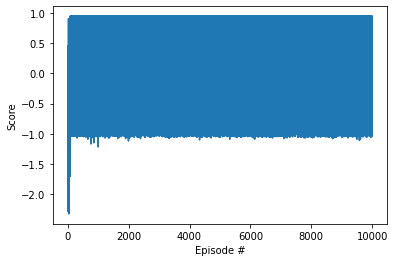

In [100]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(t.scores)), t.scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

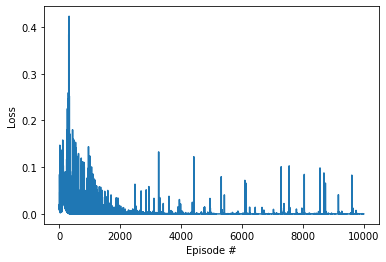

In [101]:
# plot the mean losses
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(t.mean_losses)), t.mean_losses)
plt.ylabel('Loss')
plt.xlabel('Episode #')
plt.show()

In [102]:
# Test the best solution from an Agent (with a neural network)

def remove_env():
    env_dict = gym.envs.registration.registry.env_specs.copy()

    for env in env_dict:
        if 'FrozenLakeNotSlippery-v0' in env:
            print("Remove {} from registry".format(env))
            del gym.envs.registration.registry.env_specs[env]

def register_env():
    register(
           id="FrozenLakeNotSlippery-v0",
           entry_point='gym.envs.toy_text:FrozenLakeEnv',
           kwargs={'desc' : None, 'map_name': '4x4', 'is_slippery': False},
    )
    
def make_env(env):
    env = gym.make("FrozenLakeNotSlippery-v0")

    
remove_env()
register_env()
make_env(env)
state = env.reset()
env.render()

done = False

while not done:
    agent_out = t.agent(state).detach()
    action = np.argmax(agent_out).item()
    print("Take action {}".format(action))
    state, reward, done, _ = env.step(action)
    env.render()

env.close()


Remove FrozenLakeNotSlippery-v0 from registry

SFFF
FHFH
FFFH
HFFG
Take action 2
  (Right)
SFFF
FHFH
FFFH
HFFG
Take action 2
  (Right)
SFFF
FHFH
FFFH
HFFG
Take action 1
  (Down)
SFFF
FHFH
FFFH
HFFG
Take action 1
  (Down)
SFFF
FHFH
FFFH
HFFG
Take action 1
  (Down)
SFFF
FHFH
FFFH
HFFG
Take action 2
  (Right)
SFFF
FHFH
FFFH
HFFG


In [14]:
# Example to Save model
#t = Trainer(env)
torch.save(t.agent.state_dict(), 'frozen_lake_4_4.pth')

In [9]:
# Example to Load model
t = Trainer(env)
t.agent.load_state_dict(torch.load('frozen_lake_4_4.pth'))

<All keys matched successfully>

In [103]:
# If you got that error after a registration :
# Error: Cannot re-register id: FrozenLakeNotSlippery-v1
# So you need to delete an env registered

env_dict = gym.envs.registration.registry.env_specs.copy()

for env in env_dict:
    if 'FrozenLakeNotSlippery-v1' in env:
        print("Remove {} from registry".format(env))
        del gym.envs.registration.registry.env_specs[env]


Remove FrozenLakeNotSlippery-v1 from registry


In [104]:
register(
   id="FrozenLakeNotSlippery-v1",
   entry_point='gym.envs.toy_text:FrozenLakeEnv',
   kwargs={'map_name': '8x8', 'is_slippery': False},
)

env2 = gym.make("FrozenLakeNotSlippery-v1")

In [105]:
env2.reset()
env2.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [106]:
print(env2.desc)

desc = env2.desc.tolist()
desc = [[c.decode("utf-8") for c in line] for line in desc]
print(desc)

index_of_goal = env2.observation_space.n - 1
print("Index of Goal = {}".format(index_of_goal))

l2 = get_index_of_holes(env2)
print("Indexes of Holes = {}".format(l2))

[[b'S' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'H' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'H' b'H' b'F' b'F' b'F' b'H' b'F']
 [b'F' b'H' b'F' b'F' b'H' b'F' b'H' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'G']]
[['S', 'F', 'F', 'F', 'F', 'F', 'F', 'F'], ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F'], ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'F'], ['F', 'F', 'F', 'F', 'F', 'H', 'F', 'F'], ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'F'], ['F', 'H', 'H', 'F', 'F', 'F', 'H', 'F'], ['F', 'H', 'F', 'F', 'H', 'F', 'H', 'F'], ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'G']]
Index of Goal = 63
Indexes of Holes = [19, 29, 35, 41, 42, 46, 49, 52, 54, 59]


In [112]:
# Use Trainer class to train Agent network
t = Trainer(env2)
t.train(2000)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

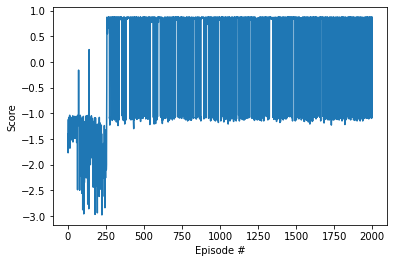

In [113]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(t.scores)), t.scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

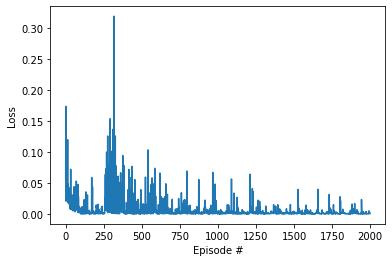

In [114]:
# plot the mean losses
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(t.mean_losses)), t.mean_losses)
plt.ylabel('Loss')
plt.xlabel('Episode #')
plt.show()

In [116]:
# Test the best solution from an Agent (with a neural network)

def remove_env():
    env_dict = gym.envs.registration.registry.env_specs.copy()

    for env in env_dict:
        if 'FrozenLakeNotSlippery-v1' in env:
            print("Remove {} from registry".format(env))
            del gym.envs.registration.registry.env_specs[env]

def register_env():
    register(
           id="FrozenLakeNotSlippery-v1",
           entry_point='gym.envs.toy_text:FrozenLakeEnv',
           kwargs={'map_name': '8x8', 'is_slippery': False},
    )
    
def make_env():
    env = gym.make("FrozenLakeNotSlippery-v1")
    return env


remove_env()
register_env()
env_8_8 = make_env()
state = env_8_8.reset()
env_8_8.render()

done = False

while not done:
    agent_out = t.agent(state).detach()
    action = np.argmax(agent_out).item()
    print("Take action {}".format(action))
    state, reward, done, _ = env_8_8.step(action)
    env_8_8.render()

env_8_8.close()

Remove FrozenLakeNotSlippery-v1 from registry

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Take action 1
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Take action 2
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Take action 1
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Take action 2
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Take action 1
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Take action 2
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Take action 2
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Take action 1
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Take action 1
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Take action 2
  (Right

In [120]:
def remove_env():
    env_dict = gym.envs.registration.registry.env_specs.copy()

    for env in env_dict:
        if 'FrozenLakeNotSlippery-v1' in env:
            print("Remove {} from registry".format(env))
            del gym.envs.registration.registry.env_specs[env]

def register_env():
    register(
           id="FrozenLakeNotSlippery-v1",
           entry_point='gym.envs.toy_text:FrozenLakeEnv',
           kwargs={'desc' : None, 'map_name': None, 'is_slippery': False},
           #kwargs={'map_name': '8x8', 'is_slippery': False},
    )
    
def make_env():
    env = gym.make("FrozenLakeNotSlippery-v1")
    return env


remove_env()
register_env()
env_8_8 = make_env()
env_8_8.render()
print(get_index_of_holes(env_8_8))
env_8_8.close()
print("=================")
env_8_8 = make_env()
env_8_8.render()
print(get_index_of_holes(env_8_8))
env_8_8.close()


Remove FrozenLakeNotSlippery-v1 from registry

SFFFFFFH
FHHFFFFF
FFFFFFFF
HFFFFFFF
FHHHFHFH
FFFFFHFF
FFHFFFFH
FFFFHHFG
[7, 9, 10, 24, 33, 34, 35, 37, 39, 45, 50, 55, 60, 61]

SFFFFHFF
FHFFFFHF
FFHFHHFH
FFFFFFHF
HFFFFHHF
FFHFFHHF
FHFHFHHF
FHFHFFFG
[5, 9, 14, 18, 20, 21, 23, 30, 32, 37, 38, 42, 45, 46, 49, 51, 53, 54, 57, 59]


In [125]:
def remove_env():
    env_dict = gym.envs.registration.registry.env_specs.copy()

    for env in env_dict:
        if 'FrozenLakeNotSlippery-v1' in env:
            print("Remove {} from registry".format(env))
            del gym.envs.registration.registry.env_specs[env]

def register_env():
    register(
           id="FrozenLakeNotSlippery-v1",
           entry_point='gym.envs.toy_text:FrozenLakeEnv',
           kwargs={'desc' : None, 'map_name': None, 'is_slippery': False},
           #kwargs={'map_name': '8x8', 'is_slippery': False},
    )
    
def make_env():
    env = gym.make("FrozenLakeNotSlippery-v1")
    return env

remove_env()
register_env()

env_8_8 = make_env()
t = Trainer(env_8_8)

for i in range(500):
    env_8_8.render()
    print("Train env i = {}".format(i))
    t.train(300)
    env_8_8.close()
    env_8_8 = make_env()
    t.update_env(env_8_8)

env_8_8.close()


print("Testing !")
env_8_8 = make_env()
state = env_8_8.reset()
env_8_8.render()

done = False

while not done:
    agent_out = t.agent(state).detach()
    action = np.argmax(agent_out).item()
    print("Take action {}".format(action))
    state, reward, done, _ = env_8_8.step(action)
    env_8_8.render()

env_8_8.close()

Remove FrozenLakeNotSlippery-v1 from registry

SFFHFHHF
FFFHHFFH
HFFFFFHF
FFFFFFFF
FHFFHHHH
HHFFHFFF
FFHFFFFH
FFFFFFFG
Train env i = 0
............................................................................................................................................................................................................................................................................................................Train is done !

SFFFFFFH
FFHHFFFH
FHFFFFFF
FFFFFFFF
FHFFFFFF
HFFHFFFF
FFFFFFFF
FFFFFHFG
Train env i = 1
............................................................................................................................................................................................................................................................................................................Train is done !

SFFFFFFH
FHFHFFFF
FFFFFFFF
HHFFHFHF
FFFFFHHF
FFFFHFFF
HFHFFFHF
FFFHHFFG
Train env i = 2
.......................................................

............................................................................................................................................................................................................................................................................................................Train is done !

SFFFHFFF
FFHFFFFF
FFFFFFHF
HFFHFFFF
FFFFFFFF
FFFFFHFF
HFHFFFFH
FFHFFFFG
Train env i = 20
............................................................................................................................................................................................................................................................................................................Train is done !

SHFFFFFH
FFFFHFFF
FHFHFFFF
FFFFHFFF
FFFFFHFF
FHFFHHFF
FFFFFHFH
HFFFFFFG
Train env i = 21
............................................................................................................................................................................................

KeyboardInterrupt: 

In [21]:
# Example to Save model
#t = Trainer(env)
torch.save(t.agent.state_dict(), 'frozen_lake_8_8.pth')

In [15]:
# Example to Load model
t = Trainer(env2)
t.agent.load_state_dict(torch.load('frozen_lake_8_8.pth'))

<All keys matched successfully>